In [2]:
import time
import numpy as np
import os
import random
import math
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import scipy.misc as misc
import copy
%matplotlib inline

C:\Users\Seth\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
data_directory = "/data/"
training_filename = "training.csv"
batch_size = 128

# Images are 96 x 96 grayscale with 15 features using (x, y) coordinates
image_size = 96
num_channels = 1 # grayscale
num_classes = 30


In [4]:
def rotatePoint(centerPoint,point,angle):
    
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

In [5]:
def _sldict(arr, sl):
    if isinstance(arr, dict):
        return {k: v[sl] for k, v in arr.items()}
    else:
        return arr[sl]

In [6]:
def _shuffle_arrays(arrays, random):
    rstate = random.get_state()
    for array in arrays:
        if isinstance(array, dict):
            for v in list(array.values()):
                random.set_state(rstate)
                random.shuffle(v)
        else:
            random.set_state(rstate)
            random.shuffle(array)

In [7]:
class BatchIterator(object):
    def __init__(self, batch_size, shuffle=False, seed=42):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, X, y=None):
        if self.shuffle:
            _shuffle_arrays([X, y] if y is not None else [X], self.random)
        self.X, self.y = X, y
        return self

        
    def __iter__(self):
        bs = self.batch_size
        for i in range((self.n_samples + bs - 1) // bs):
            sl = slice(i * bs, (i + 1) * bs)
            Xb = _sldict(self.X, sl)
            if self.y is not None:
                yb = _sldict(self.y, sl)
            else:
                yb = None
            yield self.transform(Xb, yb)
            

    @property
    def n_samples(self):
        X = self.X
        if isinstance(X, dict):
            return len(list(X.values())[0])
        else:
            return len(X)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state

In [8]:
class FlipBatchIterator(BatchIterator):
    """
    Batch iterator that randomly flips a defined portion of dataset horizontally.
    """
    
    flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb

In [11]:
class AugBatchIterator(MiniBatchIterator):
    
    def __init__(self, batch_size, shuffle=False, seed=1, add_flips=False, add_noise=False, add_bright=False, add_rotate=False):
        super(AugBatchIterator, self).__init__(batch_size, shuffle=False, seed=1)
        self.add_flips = add_flips
        self.add_noise = add_noise
        self.add_bright = add_bright
        self.add_rotate = add_rotate
        self.flip_indices = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]
    def transform(self, Xb, yb):
        Xb, yb = super(AugBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, int(bs / 2), replace=False)
        Xb[indices] = Xb[indices, :, ::-1, :]

        if yb is not None:
            # Horizontal flip of all x coordinates:
            yb[indices, ::2] = yb[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in self.flip_indices:
                yb[indices, a], yb[indices, b] = (
                    yb[indices, b], yb[indices, a])

        return Xb, yb
    '''
        if bright:
            data_shape = x_temp.shape[0]
            indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
            #print(x_temp[0,0])
            x_temp[indices] = x_temp[indices]*random.uniform(0.55, 1.55)

        
        if noise:
            data_shape = x_temp.shape[0]
            indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
            x_temp[indices] = x_temp[indices] + np.random.normal(-0.3, 0.3) * x_temp[indices].std() * np.random.random(x_temp[indices].shape)


        if rotate:
            for i in range(0, len(x_temp)):
                val = random.uniform(0, 1)
                if val > .5:
                    angle = random.uniform(0, 0) 
                    x_temp[i] = np.reshape(misc.imrotate(np.reshape(x_temp[i], [image_size, image_size]), -angle), [image_size, image_size, 1])
                    for j in range(0, 30, 2):
                        y_temp[i, j], y_temp[i, j+1] = rotatePoint((0, 0), (y_temp[i, j], y_temp[i, j+1]), angle)

'''
        

In [12]:
def load(test = False, cols = None):
    """
    Loads the dataset.
    
    Parameters
    ----------
    test     : optional, defaults to `False`
               Flag indicating if we need to load from `FTEST` (`True`) or FTRAIN (`False`)
    cols     : optional, defaults to `None`
               A list of columns you're interested in. If specified only returns these columns.
    Returns
    -------
    A tuple of X and y, if `test` was set to `True` y contains `None`.    
    """
    
    fname = FTEST if test else FTRAIN
    df = pd.read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


In [13]:
def load2d(test = False, cols = None):
    X, y = load(test = test)
    X = X.reshape(-1, image_size, image_size, num_channels)
    return X, y

In [14]:
FROOT = os.getcwd() # Path to your project folder
FTRAIN = FROOT + '/data/training.csv'
FTEST = FROOT + '/data/test.csv'
FLOOKUP = FROOT + '/data/IdLookupTable.csv'

image_values, image_labels = load2d()
#image_values = np.reshape(image_values, [-1, image_size, image_size, 1])

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [18]:
len(image_values)

2140

In [19]:
def splitData(data, data2, percentage):
    data11 = data[:int(len(data)*percentage)]
    data12 = data[int(len(data)*percentage):]
    
    data21 = data2[:int(len(data2)*percentage)]
    data22 = data2[int(len(data2)*percentage):]
    
    return data11, data12, data21, data22

## Train/Validation/Test Split

In [15]:
train_images, test_images, train_labels, test_labels = train_test_split(image_values, image_labels, test_size = 0.3)
test_images, valid_images, test_labels, valid_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [15]:
train_images, valid_images, train_labels, valid_labels = splitData(image_values, image_labels, 0.7)

valid_images, test_images, valid_labels, test_labels = splitData(valid_images, valid_labels, 0.5)

In [96]:
def conv_relu(input, kernel_size, depth):
    """
    Creates a convolutional TensorFlow layer followed by a ReLU.
    
    Parameters
    ----------
    input         : 
                    Input tensor for calculating layer shape.
    kernel_size   : 
                    Kernel size, we assume a square kernel.
    depth         : 
                    Layer depth, e.g. number of units.
               
    Returns
    -------
    A graph variable calculating convolutional layer with applied ReLU.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer=tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides=[1, 1, 1, 1], padding='SAME')
    return tf.nn.relu(conv + biases)

In [97]:
def fully_connected(input, size):
    """
    Creates a fully connected TensorFlow layer.
    
    Parameters
    ----------
    input  : 
            Input tensor for calculating layer shape.
    size   : 
            Layer size, e.g. number of units.
               
    Returns
    -------
    A graph variable calculating single fully connected layer.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    """
    Creates a fully connected TensorFlow layer with ReLU non-linearity applied.
    """
    return tf.nn.relu(fully_connected(input, size))

In [98]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLU in graph
    # 
    print("Created RELU Activation Function")
    return tf.nn.relu(x_input)

In [99]:
def pool(input, size):
    """
    Performs max pooling.
    
    Parameters
    ----------
    input  : 
            Input tensor.
    size   : 
            Pooling kernel size, assuming it's square.
               
    Returns
    -------
    A graph variable calculating single max pooling layer.
    """
    return tf.nn.max_pool(
        input, 
        ksize=[1, size, size, 1], 
        strides=[1, size, size, 1], 
        padding='SAME'
    )

In [100]:
def createSimpleNetwork(model_input):
    with tf.variable_scope('input'):
        input_layer = tf.reshape(model_input, [-1, image_size * image_size])
    with tf.variable_scope('hidden'):
        hidden_fully_connected_layer = createFullyConnectedLayer(input_layer, 100)
    relu_layer = createLinearRectifier(hidden_fully_connected_layer)
    with tf.variable_scope('out'):
        model_output = createFullyConnectedLayer(relu_layer, 30)
        
    print("Simple Network Created")
    return model_output

In [1]:
def createConvNetwork(input, training):
    """
    Performs a whole model pass.
    
    Parameters
    ----------
    input     : 
                Input tensor to be passed through the model.
    training  : 
                Tensorflow flag indicating if we are training or evaluating our model 
                (so that we know if we should apply dropout).
    Returns
    -------
    Model prediction.
    """
    # Convolutional layers
    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = 3, depth = 32) 
        pool1 = pool(conv1, size = 2)
        # Apply dropout if needed
        pooling_layer1 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer1, keep_prob = 0.9 if dropout else 1.0), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = 2, depth = 64)
        pool2 = pool(conv2, size = 2)
        # Apply dropout if needed
        pooling_layer2 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer2, keep_prob = 0.9 if dropout else 1.0), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = 2, depth = 128)
        pool3 = pool(conv3, size = 2)
        # Apply dropout if needed
        pooling_layer3 = tf.cond(is_train, lambda: tf.nn.dropout(pooling_layer1, keep_prob = 0.9 if dropout else 1.0), lambda: pooling_layer3)
    
    # Flatten convolutional layers output
    shape = pool3.get_shape().as_list()
    flattened = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    # Fully connected layers
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, size = 1000)
        # Apply dropout if needed
        fc4 = tf.cond(training, lambda: tf.nn.dropout(fc4, keep_prob = 0.5 if dropout else 1.0), lambda: fc4)
    with tf.variable_scope('fc5'):
        fc5 = fully_connected_relu(fc4, size = 1000)
    with tf.variable_scope('out'):
        prediction = fully_connected(fc5, size = 30)
    return prediction

In [102]:
def getPredictions(values, session):
    predictions = []
    batch = BatchIterator(batch_size = 128)
    for batch_values, _ in batch(values):
        prediction_batch = session.run(model_predictions, feed_dict = {model_input : batch_values, model_training : False})
        predictions.extend(prediction_batch)
    return predictions

In [103]:
def getLoss(values, labels, session):
    loss = []
    batch = BatchIterator(batch_size = 128)
    for batch_values, batch_labels in batch(values, labels):
        loss_batch = session.run(model_loss, feed_dict = {model_input : batch_values, model_output : batch_labels, model_training : False})
        loss.append(loss_batch)
    return np.mean(loss)

In [104]:
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [105]:
def saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, name):
    df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})
    writer = pd.ExcelWriter(model_path + name + '.xlsx', engine='xlsxwriter')
    df.to_excel(writer, sheet_name='Sheet1')
    writer.save()

In [115]:
def trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate):
    start = time.time()
    train_loss_list = []
    valid_loss_list = []
    time_list = []
    epoch_list = []
    print("TRAINING: " + model_name)

    with tf.Session(graph = graph) as session:

        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if os.path.exists(model_directory):
            print("Loading model...")
            load_path = saver.restore(session, model_path)

        for epoch in range(num_epochs):
            current_epoch = epoch
            #batch = AugBatchIterator(batch_size=batch_size, shuffle=True, add_flips=True, add_noise=False, add_bright=False, add_rotate=False)
            batch = FlipBatchIterator(batch_size=batch_size, shuffle=True)
            
            for batch_data, batch_labels in batch(train_images, train_labels):
                feed_dict = {model_input: batch_data, model_output: batch_labels, model_training: True}
                # train model
                session.run([model_optimizer], feed_dict = feed_dict)

            #Store train and validation losses
            if current_epoch % 10 == 0:
                train_loss = getLoss(train_images, train_labels, session)
                train_loss_list.append(train_loss)
                valid_loss = getLoss(valid_images, valid_labels, session)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)
                print("Epoch[%4d]" % epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate.eval() + "%f" % momentum_rate)

                time_list.append(current_time)
                epoch_list.append(current_epoch)

            if current_epoch % 300 == 0:
                if not os.path.exists(model_directory):
                    os.mkdir(model_directory)
                print("Saving Model...")    
                save_path = saver.save(session, model_path)
            # Evaluate on test dataset.
        test_loss = getLoss(test_images, test_labels, session)
        print(" Test score: %.3f (loss = %.8f)" % (np.sqrt(test_loss) * 48.0, test_loss)) #RMSE
        if not os.path.exists(model_directory):
            os.mkdir(model_directory)
        print("Saving Model...")
        save_path = saver.save(session, model_path)
        saveModelHistory(epoch_list, time_list, train_loss_list, valid_loss_list, 'Loss3')

In [114]:
#Model Name
model_name = "ConvNet-Test224decay"
model_filename = model_name + ".ckpt"
model_directory = os.getcwd() + "/Models5/" + model_name
model_path = model_directory + "/" + model_filename

graph = tf.Graph()

with graph.as_default():
    
    model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
    model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
    model_training = tf.placeholder(tf.bool)
    
    current_epoch = tf.Variable(0)
    #Define Parameters
    num_epochs=300

    learning_rate = tf.train.exponential_decay(0.03, current_epoch, decay_steps=num_epochs, decay_rate=0.03)
    #learning_rate = 0.03
    dropout = True

    m_min = 0.9
    m_max = 0.99
    #momentum_rate = m_min + (m_max - m_min) * (current_epoch / num_epochs)
    momentum_rate = 0.9
    # get model
    #with tf.variable_scope(model_name):
    #    model_predictions = createSimpleNetwork(model_input)
    with tf.variable_scope(model_name):
        model_predictions = createConvNetwork(model_input, model_training)
    
    model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))
    
    model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
    #model_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
    #model_optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(model_loss)


In [108]:
def get_time_hhmmss(start):
    """
    Calculates time since `start` and formats as a string.
    
    Parameters
    ----------
    start :  
            Time starting point.
               
    Returns
    -------
    Nicely formatted time difference between now and `start`.
    """
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

In [109]:
def get_predictions_in_batches(X, session):
    """
    Calculates predictions in batches of 128 examples at a time, using `session`'s calculation graph.
    
    Parameters
    ----------
    X       : ndarray
              Dataset to get predictions for.
    session :
              TensorFlow session to be used for predicting. Is expected to have a `predictions` var 
              in the graph along with a `tf_x_batch` placeholder for incoming data.
               
    Returns
    -------
    N-dimensional array of predictions.
    """
    p = []
    batch_iterator = BatchIterator(batch_size = 128)
    for x_batch, _ in batch_iterator(X):
        [p_batch] = session.run([model_predictions], feed_dict = {
                model_input : x_batch,
                model_training : False
            }
        )
        p.extend(p_batch)
    return p

In [34]:
def calc_loss(predictions, labels):
    """
    Calculates loss with NumPy.
    
    Parameters
    ----------
    predictions : ndarray 
                  Predictions.
    labels      : ndarray
                  Actual values.
               
    Returns
    -------
    Squared mean error for given predictions.
    """
    return np.mean(np.square(predictions - labels))

In [ ]:
d

In [116]:
flip = True
rotate = False
noise = False
bright = False

trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate)

TRAINING: ConvNet-Test224decay
Epoch[   0]0: 0: 1 0.039451  0.041354 0.030000 0.900000
Saving Model...
Epoch[  10]0: 0:11 0.010970  0.011642 0.030000 0.900000
Epoch[  20]0: 0:20 0.009125  0.009707 0.030000 0.900000
Epoch[  30]0: 0:29 0.007572  0.008067 0.030000 0.900000
Epoch[  40]0: 0:38 0.007034  0.007479 0.030000 0.900000
Epoch[  50]0: 0:47 0.006429  0.006864 0.030000 0.900000
Epoch[  60]0: 0:56 0.005996  0.006407 0.030000 0.900000
Epoch[  70]0: 1: 5 0.005742  0.006120 0.030000 0.900000
Epoch[  80]0: 1:14 0.005604  0.006003 0.030000 0.900000
Epoch[  90]0: 1:23 0.005265  0.005613 0.030000 0.900000
Epoch[ 100]0: 1:33 0.005342  0.005700 0.030000 0.900000
Epoch[ 110]0: 1:42 0.005004  0.005325 0.030000 0.900000
Epoch[ 120]0: 1:51 0.005033  0.005353 0.030000 0.900000
Epoch[ 130]0: 2: 0 0.004879  0.005181 0.030000 0.900000
Epoch[ 140]0: 2: 9 0.004721  0.005009 0.030000 0.900000
Epoch[ 150]0: 2:18 0.004554  0.004834 0.030000 0.900000
Epoch[ 160]0: 2:27 0.004581  0.004875 0.030000 0.900000
E

### Cross Validate via KFolds

In [57]:
image_values.shape

(2140, 96, 96, 1)

In [60]:
image_values.shape

(2140, 96, 96, 1)

In [68]:
skf = KFold(n_splits=kfolds, random_state=None, shuffle=False)
for train_index, test_index in skf.split(image_values):
    print(i)
    kfolds2 = 5
    momentum_rate = momentum_steps[i]
    train_images1 = np.asarray([image_values[i] for i in train_index])
    print(train_images1.shape)

0
(1712, 96, 96, 1)
0
(1712, 96, 96, 1)
0
(1712, 96, 96, 1)
0
(1712, 96, 96, 1)
0
(1712, 96, 96, 1)


# Cross Validation Tests for Parameter Tuning

In [85]:
kfolds = 5
#kfolds loop
#new name
#train
print("hello")
momentum_steps = [0.1, 0.3, 0.5, 0.7, 0.9] 

learning_steps = [0.0001, 0.001, 0.01, 0.1, 1]


skf = KFold(n_splits=kfolds, random_state=None, shuffle=False)
i = 0
for train_index, test_index in skf.split(image_values):
    print(i)
    kfolds2 = 5
    momentum_rate = momentum_steps[i]
    train_images1 = [image_values[i] for i in train_index]
    train_labels1 = [image_labels[i] for i in train_index]
    
    test_images = [image_values[i] for i in test_index]
    test_labels = [image_labels[i] for i in test_index]
    j = 0
    skf2 = KFold(n_splits=kfolds2, random_state=None, shuffle=False)
    for train_index2, valid_index in skf2.split(train_images1):
        print(j)
        learning_rate = learning_steps[j]
        
        train_images = np.asarray([train_images1[i] for i in train_index2])
        train_labels = np.asarray([train_labels1[i] for i in train_index2])
        valid_images = np.asarray([train_images1[i] for i in valid_index])
        valid_labels = np.asarray([train_labels1[i] for i in valid_index])
        
        #Model Name
        model_name = "ConvNet-Best-CV" + "Mom" + str(momentum_rate) + str("LRN") + str(learning_rate) 
        model_filename = model_name + ".ckpt"
        model_directory = os.getcwd() + "/Models5/" + model_name
        model_path = model_directory + "/" + model_filename
    
        
        graph = tf.Graph()

        with graph.as_default():

            model_input = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels))
            model_output = tf.placeholder(tf.float32, shape=(None, num_classes))
            model_training = tf.placeholder(tf.bool)

            current_epoch = tf.Variable(0)
            #Define Parameters
            num_epochs=200
            dropout = True


            # get model
            #with tf.variable_scope(model_name):
            #    model_predictions = createSimpleNetwork(model_input)
            with tf.variable_scope(model_name):
                model_predictions = createConvNetwork(model_input, model_training)

            model_loss = tf.reduce_mean(tf.square(model_predictions - model_output))

            model_optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(model_loss)
        
        print("hello")

        trainModel(train_images, train_labels, valid_images, valid_labels, test_images, test_labels, num_epochs, batch_size, model_name, flip, noise, bright, rotate)
        
        j = j + 1
    i = i + 1

hello
0
0
hello
TRAINING: ConvNet-Best-CVMom0.1LRN0.0001
Epoch[   0]0: 0: 1 0.154463  0.154061 0.000100 0.100000
Saving Model...
Epoch[  10]0: 0:10 0.145328  0.145034 0.000100 0.100000
Epoch[  20]0: 0:19 0.137519  0.137191 0.000100 0.100000
Epoch[  30]0: 0:27 0.130592  0.130167 0.000100 0.100000
Epoch[  40]0: 0:36 0.124034  0.123760 0.000100 0.100000
Epoch[  50]0: 0:44 0.118347  0.117837 0.000100 0.100000
Epoch[  60]0: 0:52 0.112758  0.112274 0.000100 0.100000
Epoch[  70]0: 1: 0 0.107314  0.107031 0.000100 0.100000
Epoch[  80]0: 1: 9 0.102418  0.102058 0.000100 0.100000
Epoch[  90]0: 1:17 0.097738  0.097314 0.000100 0.100000
Epoch[ 100]0: 1:25 0.093139  0.092788 0.000100 0.100000
Epoch[ 110]0: 1:34 0.088784  0.088477 0.000100 0.100000
Epoch[ 120]0: 1:42 0.084706  0.084349 0.000100 0.100000
Epoch[ 130]0: 1:50 0.080752  0.080419 0.000100 0.100000
Epoch[ 140]0: 1:59 0.077039  0.076689 0.000100 0.100000
Epoch[ 150]0: 2: 7 0.073409  0.073169 0.000100 0.100000
Epoch[ 160]0: 2:15 0.070082  0.

In [73]:
np.array(images).shape

NameError: name 'images' is not defined

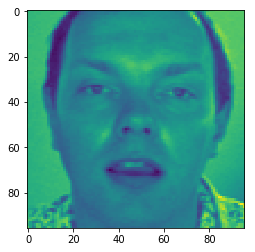

KeyboardInterrupt: 

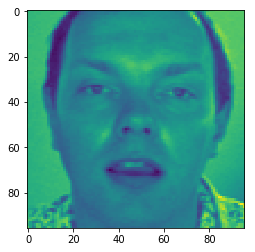

In [51]:
from IPython import display

flip = False
rotate = False
noise = False
bright = False

batch = AugBatchIterator(batch_size=batch_size, shuffle=True, add_flips=flip, add_noise=noise, add_bright=bright, add_rotate=rotate)
for batch_data in train_images:
    
    plt.imshow(np.resize(batch_data[5], [image_size, image_size]))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1.0)

In [139]:
x_temp = copy.deepcopy(valid_images[0])
y_temp = copy.deepcopy(valid_labels[0])
angle = random.uniform(0, 0) 
x_temp = np.reshape(misc.imrotate(np.reshape(x_temp, [image_size, image_size]), -angle), [image_size, image_size, 1])
for j in range(0, 30, 2):
    y_temp[j], y_temp[j+1] = rotatePoint((0, 0), (y_temp[j], y_temp[j+1]), angle)


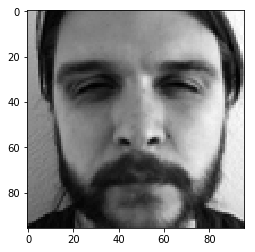

In [85]:
import matplotlib.image as mpimg

new_image = mpimg.imread('sethdecker2.jpg')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])


#new_image = rgb2gray(new_image.reshape(96, 96, 1))
plt.imshow(new_image)

new_image = new_image / 255

plt.imshow(new_image, cmap="gray")

In [92]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    
    pred = session.run(model_predictions, feed_dict={model_input: np.reshape(new_image, [1, 96, 96, 1]), model_training:False})
    #pred = session.run(model_predictions, feed_dict={model_input: test_images, model_training:False})
    #valid_loss = getLoss(valid_images, valid_labels, session)
    #loss = session.run(loss_function, feed_dict={tf_x_batch: x_valid, y_output: y_valid, is_training:False})
    #print(loss)

ValueError: cannot reshape array of size 15777792 into shape (96,96)

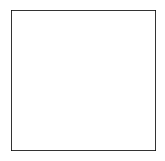

In [59]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = train_images[i]
    #img = new_image
    img = np.reshape(img, [96, 96])
    #y = y_test[i]
    #y2 = pred
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    #axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

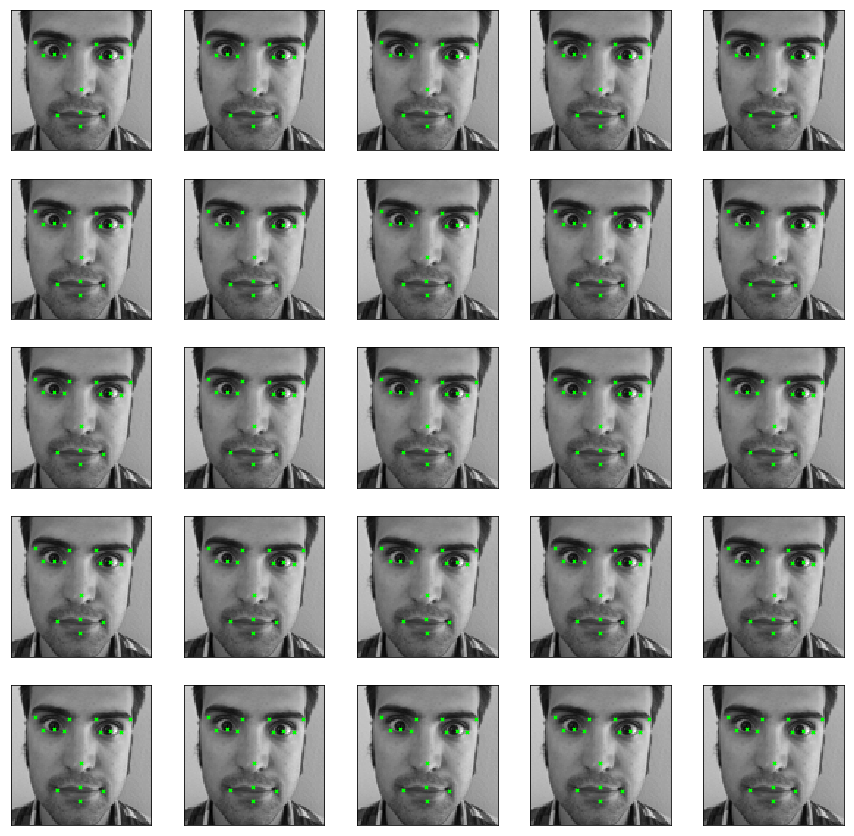

In [81]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = new_image
    img = img.reshape(96, 96)
    #y = y_test[i]
    y2 = pred[0]
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

In [10]:
class MiniBatchIterator(object):
    def __init__(self, batch_size, shuffle=False, seed=1):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.random = np.random.RandomState(seed)

    def __call__(self, value, label=None):
        if self.shuffle:
            _shuffle_arrays([value, label] if label is not None else [value], self.random)
        self.value, self.label = value, label
        return self

    def __iter__(self):
        for i in range((len(self.value) + self.batch_size - 1) // self.batch_size):
            slice_amount = slice(i * self.batch_size, (i + 1) * self.batch_size)
            value_slice = _slicer(self.value, slice_amount)
            if self.label is not None:
                label_slice = _slicer(self.label, slice_amount)
            else:
                label_slice = None
            yield self.transform(value_slice, label_slice)

    def transform(self, Xb, yb):
        return Xb, yb

    def __getstate__(self):
        state = dict(self.__dict__)
        for attr in ('X', 'y',):
            if attr in state:
                del state[attr]
        return state

In [10]:
def _shuffle_arrays(arrays, random):
    random_state = random.get_state()
    for array in arrays:
        random.set_state(random_state)
        random.shuffle(array)

In [11]:
def _slicer(array, slice_amount):
    return array[slice_amount]